# Module import

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure, transform, img_as_float32
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import skimage
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LabelSet
output_notebook()

import hvplot.pandas

from PIL import Image
from skimage import io, color, exposure, transform, img_as_float32
import skimage

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap
import umap.plot

from scipy import stats

from pathlib import Path
import os, sys

from dask import bag, diagnostics

from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
import leukopy_lib_EDA as eda
from importlib import reload
reload(leuko)
reload(eda)

Loading BokehJS ...

Loading BokehJS ...

<module 'leukopy_lib_EDA' from '/home/marie-anne/code/Leukopy/notebooks/leukopy_lib_EDA.py'>

**Liste des variables du DF :**

- img_path : chemin d'accès de l'image

- cell_type : même information que label, en toutes lettres

- label : 11 classes de cellule 

|Cell type|Code|Barcelona|Raabin|Munich|
|---------|----|---------|------|------|
|neutrophils (segmented)| SNE|X| |X|
|eosinophils|              EO|X|X|X|
|basophils|                BA|X|X|X|
|lymphocytes|              LY|X|X|X|
|monocytes|                MO|X|X|X|
|metamyelocytes|          MMY|X| |X|
|myelocytes|               MY|X| |X|
|promyelocytes|           PMY|X| |X|
|band neutrophils|        BNE|X| |X|
|platelets|               PLT|X| | |
|erythroblasts|           ERB|X| |X|
    

- height : hauteur en nombre de pixels
- width : largeur en nombre de pixels
- mean_brightness : luminosité moyennée sur toute l'image (couleur)
- mean_luminance : luminosité moyennée sur toute l'image (niveaux de gris)


# Import

In [60]:
path_name = '../../data/PBC_dataset_normal_df_merged.csv'
df = leuko.load_df(path_name)
df.head()

,img_path,label,label_2,origin,height,width,mean_brightness,mean_luminance
0,../../data/main_dataset_2/SNE/SNE_263049.jpg,SNE,SNE,barcelone,363,360,200.803423,0.783345
1,../../data/main_dataset_2/SNE/SNE_829664.jpg,SNE,SNE,barcelone,363,360,197.570620,0.766877
2,../../data/main_dataset_2/SNE/SNE_987578.jpg,SNE,SNE,barcelone,363,360,197.110430,0.765792
3,../../data/main_dataset_2/SNE/SNE_66862.jpg,SNE,SNE,barcelone,363,360,200.949015,0.783442
4,../../data/main_dataset_2/SNE/SNE_935764.jpg,SNE,SNE,barcelone,363,360,188.113246,0.724006


In [61]:
df.nunique()

img_path           37689
label                 11
label_2              229
origin                 3
height                34
width                 32
mean_brightness    37651
mean_luminance     37672
dtype: int64

## Class distribution

Text(0.5, 1.0, 'Class imbalance')

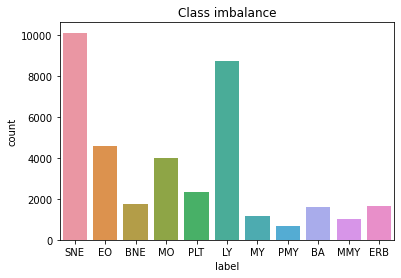

In [62]:
sns.countplot(x=df.label)
plt.title('Class imbalance')

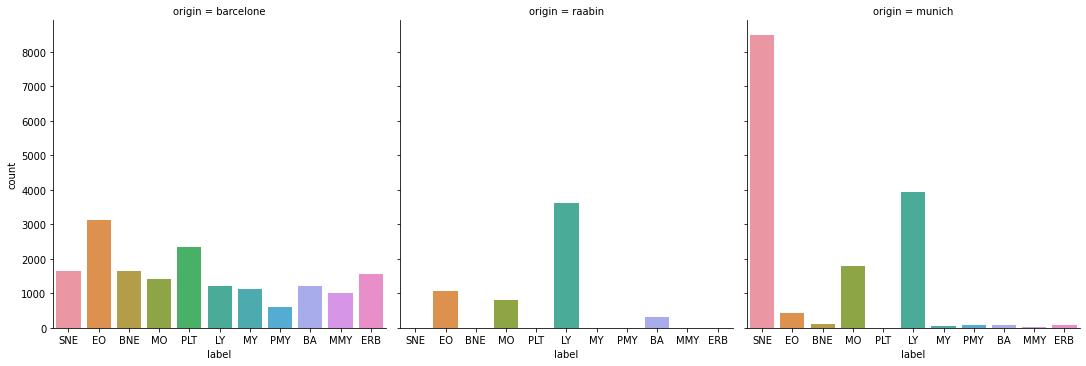

In [63]:
sns.catplot(x='label', data=df, kind='count', col='origin')

## Random image for each class

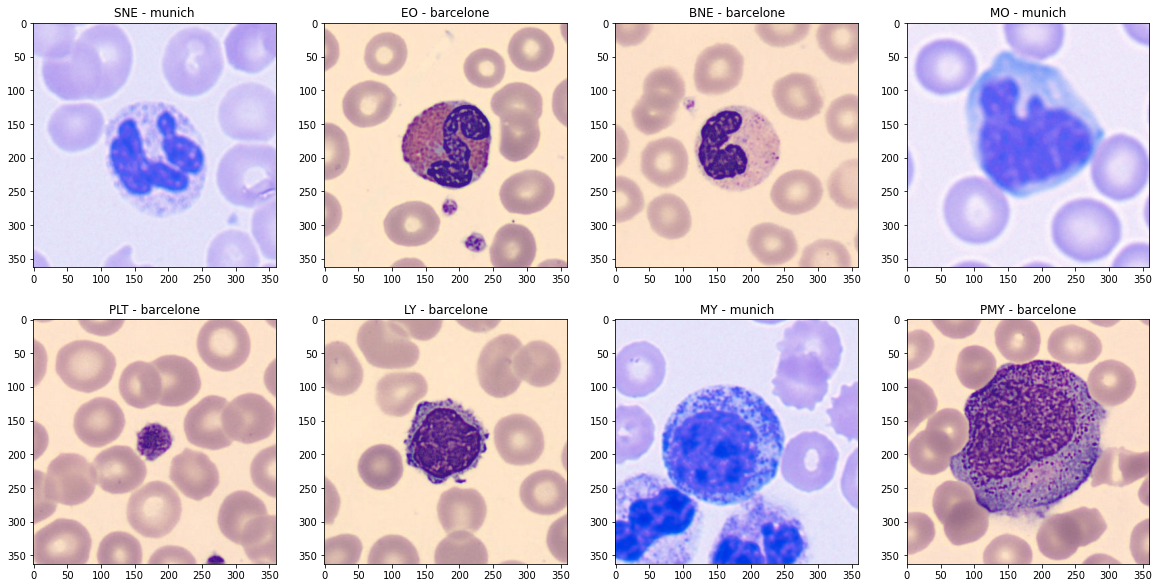

In [64]:
eda.plot_random_by_classes(df, origin=True)

## Distribution of image size

In [65]:
sizes = df.groupby(['height', 'width']).agg(origin=('origin', 'unique'), 
                                    count=('img_path', 'count')
                                   )

In [66]:
sizes.origin = sizes.origin.astype('str')

In [67]:
sizes.hvplot.scatter(x='height', y='width', size='count', color='origin',
                     xlim=(300,610), ylim=(300,610), 
                     grid=True, 
                     height=500, width=600).options(line_alpha=0.7,
                                                    line_width=2,
                                                    fill_alpha=0.04)


:Scatter   [height]   (width,origin,count)

# Brightness assessment

## Mean brightness and mean luminance distribution

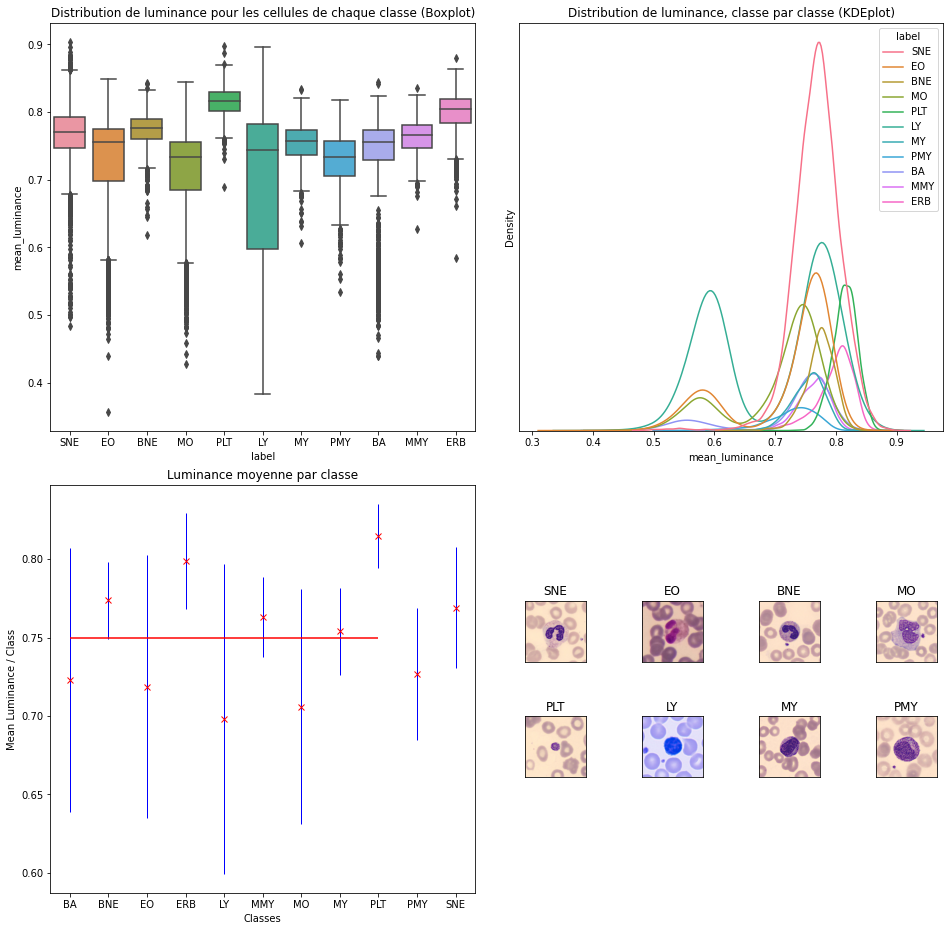

In [68]:
eda.plot_meanluminance_stats(df)

## Outliers

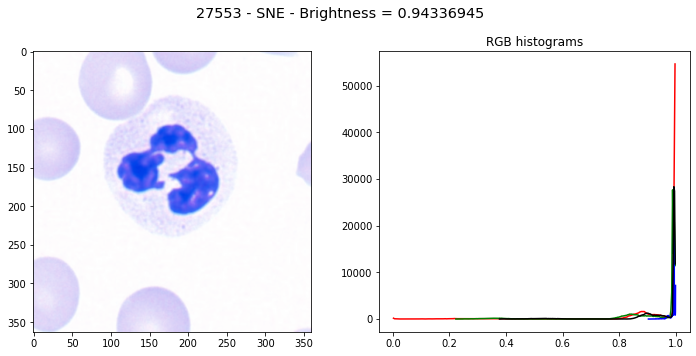

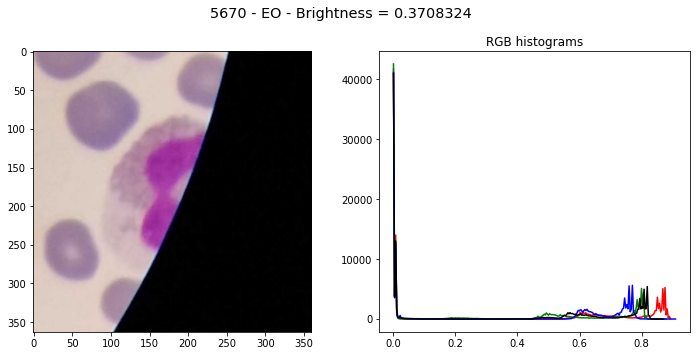

In [69]:
eda.plot_best_outliers(df, histos = True)

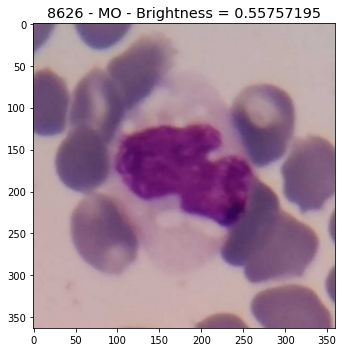

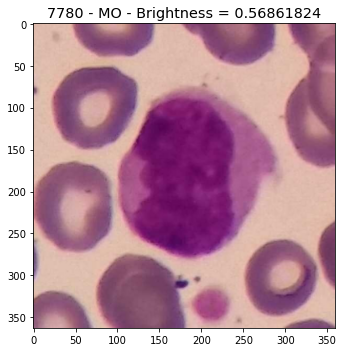

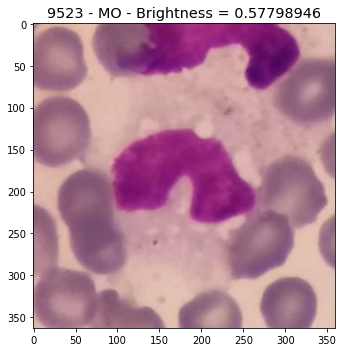

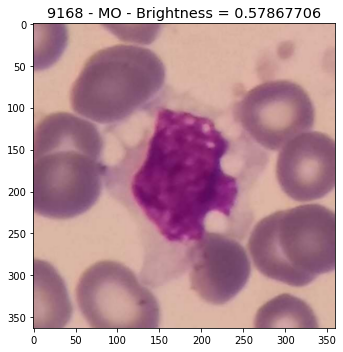

In [70]:
eda.plot_random_outliers(df, label = "MO")

# Dimension reduction

## Preprocessing

### sampling

In [71]:
sample = df.groupby('label').sample(n=300)

In [72]:
# Loading grayscaled images
dfile_bag = bag.from_sequence(sample.img_path.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())
images_flat = images.reshape(images.shape[0], -1) 

[########################################] | 100% Completed | 33.5s


In [73]:
df_data = pd.DataFrame(images_flat)

### Label encoding

In [74]:
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.label)
target_sample = target[sample.index]

## PCA embedding

In [75]:
# Applying the PCA to our data
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(df_data)

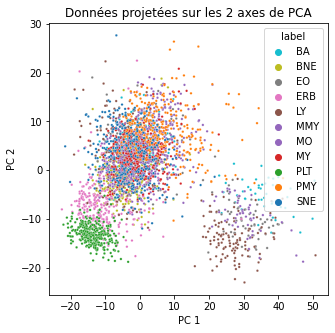

In [76]:
# Plotting our results
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue = sample["label"], s=6, palette = 'tab10_r')

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

ax.set_title("Données projetées sur les 2 axes de PCA")
plt.show()

## UMAP emdedding 

While t-SNE is really good at conserving local distance, PCA is good at conversing global structure. The UMAP algorithm is good at maintaining both. Let's have a look.

### Applying our UMAP model


In [77]:
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 2min 31s, sys: 876 ms, total: 2min 32s
Wall time: 2min 30s


In [78]:
sample['X_UMAP'] = embedding[:, 0]
sample['Y_UMAP'] = embedding[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.img_path
x_coord = sample2.X_UMAP.to_list()
y_coord = sample2.Y_UMAP.to_list()

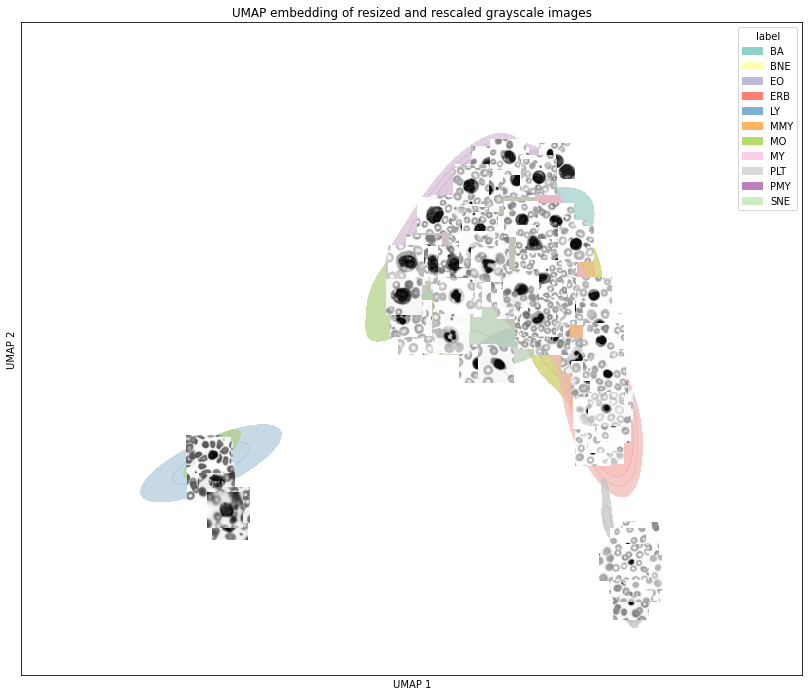

In [79]:
# Plotting the results
fig, ax = plt.subplots(1, figsize=(14, 12))
sns.kdeplot(x=embedding[:, 0], y=embedding[:, 1], hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)
    
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
plt.show()

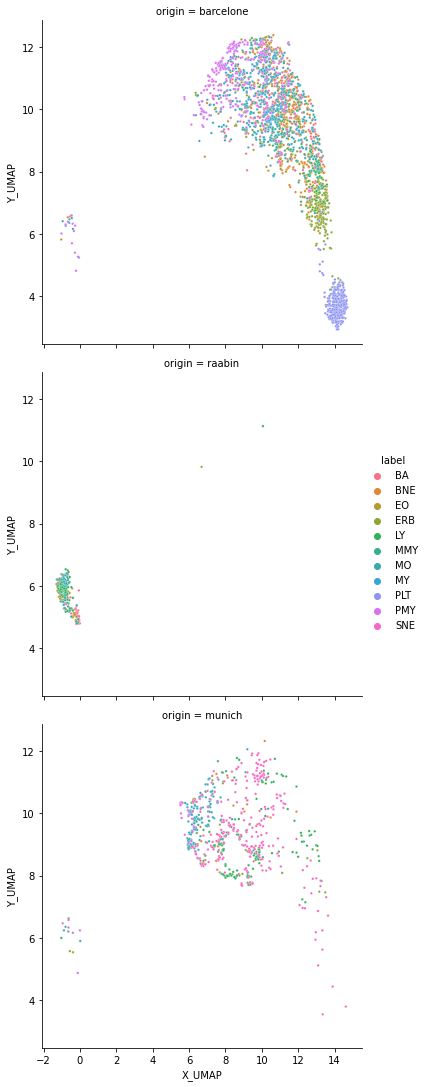

In [80]:
sns.relplot(x='X_UMAP', y='Y_UMAP', hue='label', data=sample,
            row='origin',
                s=6,)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

ax.set_title('UMAP embedding')
plt.show()

In [81]:
df[df.label=='PLT']

,img_path,label,label_2,origin,height,width,mean_brightness,mean_luminance
9677,../../data/main_dataset_2/PLT/PLATELET_828004.jpg,PLT,PLATELET,barcelone,363,360,198.149592,0.773867
9678,../../data/main_dataset_2/PLT/PLATELET_396691.jpg,PLT,PLATELET,barcelone,363,360,203.130224,0.791758
9679,../../data/main_dataset_2/PLT/PLATELET_936249.jpg,PLT,PLATELET,barcelone,363,360,201.614794,0.790775
9680,../../data/main_dataset_2/PLT/PLATELET_976216.jpg,PLT,PLATELET,barcelone,363,360,206.474204,0.807852
9681,../../data/main_dataset_2/PLT/PLATELET_191962.jpg,PLT,PLATELET,barcelone,363,360,206.965172,0.813247
...,...,...,...,...,...,...,...,...
12020,../../data/main_dataset_2/PLT/PLATELET_545289.jpg,PLT,PLATELET,barcelone,363,360,195.555650,0.758170
12021,../../data/main_dataset_2/PLT/PLATELET_317851.jpg,PLT,PLATELET,barcelone,363,360,202.750844,0.791671
12022,../../data/main_dataset_2/PLT/PLATELET_811679.jpg,PLT,PLATELET,barcelone,363,360,208.063621,0.818518
12023,../../data/main_dataset_2/PLT/PLATELET_426500.jpg,PLT,PLATELET,barcelone,363,360,208.306257,0.817029
